In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import FunctionTransformer as FT
from sklearn.impute import SimpleImputer

from lib.Datasets import TabularDataset
from lib.Transformers import NumericalTransformer, CategoricalTransformer, CategoricalTargetTransformer, DatasetTransformer
from lib.Runner import Runner

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor, Tensor
from torch.optim import Optimizer
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR
from torch.utils.data import DataLoader

##### Reproducibility

In [3]:
torch.manual_seed(0)
np.random.seed(0)

### Dataset's

In [4]:
train_df = pd.read_csv('csv/_train_2020_09_13.csv', low_memory=False)
print('{0:,} registros a las {1}'.format(len(train_df), datetime.now()))
train_df.head()

144,995 registros a las 2020-11-08 03:59:08.540422


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


In [5]:
validation_df = pd.read_csv('csv/_validation_2020_09_13.csv', low_memory=False)
print('{0:,} registros a las {1}'.format(len(validation_df), datetime.now()))
validation_df.head()

35,766 registros a las 2020-11-08 03:59:09.063674


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,6,280.245759,508.898157,19880.954667,3.340348,7.337031,8.120307,0.001,False,...,8599.0,18979.0,120.0,9517.0,1919367,19627,375891,7a81b3dc-0f1d-47b9-9ebe-6b080f0f9a78,43543000.0,GARANTIA DEL FABRICANTE 12 MESES
1,True,44,114.704700,200.589045,2239.911000,4.387991,2.588060,3.023881,0.001,False,...,867.0,5279.0,4.0,1013.0,336447,243,202158,ede61a11-5ef8-4626-86d0-2040abcb15d3,NaN,NaN
2,True,163,69.938155,120.521127,4917.262000,2.836291,4.301471,7.982026,0.001,False,...,5265.0,16769.0,90.0,9770.0,293809,1514,134501,37695e18-617e-4977-9d8d-25b963bcbfda,158491483.0,Garantía del vendedor: 15 días
3,True,99980,61.344055,43.361379,335.328000,5.504259,5.172414,12.599138,0.001,False,...,1200.0,8458.0,18.0,2923.0,98151,207,81713,6177b855-73f4-454b-92a6-84ab2870ba56,195821718.0,Garantía del vendedor: 180 días
4,True,3741,275.396775,5019.725800,8366.209667,3.506554,124.760000,139.820000,0.001,False,...,6238.0,15074.0,219.0,6991.0,1612203,21461,503854,b80c6195-ae11-4980-81a2-0b6af863abd3,322103542.0,Garantía del vendedor: 6 meses


### Test set

In [6]:
test_df = pd.read_csv('csv/test.csv', sep=',', low_memory=False)
print('{0:,} registros a las {1}'.format(len(test_df), datetime.now()))
test_df.head()

19,211 registros a las 2020-11-08 03:59:09.316394


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,4,98.426510,91.979648,3657.724000,3.589443,3.461023,4.988265,0.001,False,...,1364.0,18.0,5951.0,40954,300,100477,703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7,233223201.0,Garantia de fabrica,0
1,True,12,242.485208,821.376944,985.652333,3.215580,26.222222,28.388889,0.001,False,...,3724.0,41.0,1022.0,135133,926,44033,d714e65e-5447-4f7d-9a4e-aaa57efa6107,337881137.0,NaN,1
2,True,5,2450.533424,1365.504354,33454.856667,7.097276,14.646259,15.217687,0.001,False,...,1839.0,71.0,11185.0,204788,8457,716157,299cb623-b71c-4f9d-b792-48d5744f0449,86609353.0,Garantía de fábrica: 12 meses,2
3,True,9052,157.735448,78.692131,160.007333,4.927390,2.983607,3.524590,0.001,False,...,85528.0,44.0,215.0,1404477,1907,6580,f2060244-f0da-43db-91b7-4c1bb5f99e67,430797570.0,Sin garantía,3
4,True,37,116.891454,163.245653,4043.050667,2.937837,7.257066,19.771198,0.001,False,...,61466.0,274.0,14690.0,1466424,2633,215184,d7f3b7f4-a9fa-4bd8-a600-3f2714480779,6566243.0,Garantía de fábrica: 6 meses,4


#### To dictionaries

In [7]:
X_train = train_df.to_dict('records')
X_validation = validation_df.to_dict('records')
X_test = test_df.to_dict('records')

Y_train = train_df['conversion'].values
Y_validation = validation_df['conversion'].values

### Transformations

#### Functions

In [8]:
def get_day_of_week(X):
    dates = [datetime.strptime(x[:10], '%Y-%m-%d') for x in X]
    return [dt.weekday() for dt in dates]

def is_weekend(X):
    dates = [datetime.strptime(x[:10], '%Y-%m-%d') for x in X]
    return [not (dt.weekday() >= 0 and dt.weekday() <= 4) for dt in dates]

get_hour = lambda X: [x[11:13] for x in X]
has_tag = lambda X, tag: [tag in x for x in X]
has_value = lambda X: [not x == 'nan' for x in X]
has_warranty = lambda X: ['SIN GARAN' in x.upper() for x in X]

#def transform_tags(feature:np.ndarray) -> np.ndarray:
#    tms_1 = [value[1:-1] for value in feature]
#    tms_2 = [sorted(value.split(', ')) for value in tms_1]
#    return np.array([' '.join(value) for value in tms_2])

get_discount = lambda X: 1 - np.array(X['price'], dtype=np.float64)/np.array(X['original_price'], dtype=np.float64)

In [9]:
dataset_transformer = DatasetTransformer([
    ('free_shipping', CategoricalTransformer('free_shipping')),
    ('is_pdp', CategoricalTransformer('is_pdp')),
    ('category_id', CategoricalTransformer('category_id', handle_unknown=True)),
    ('domain_id', CategoricalTransformer('domain_id', handle_unknown=True)),
    ('product_id', CategoricalTransformer('product_id', handle_unknown=True)),
    ('item_id', CategoricalTransformer('item_id', handle_unknown=True)),
    ('listing_type_id', CategoricalTransformer('listing_type_id')),
    ('logistic_type', CategoricalTransformer('logistic_type')),
    ('platform', CategoricalTransformer('platform')),
    ('is_loggued_user', CategoricalTransformer('user_id', pre_tfms=[FT(has_value)])),
    ('has_main_picture', CategoricalTransformer('main_picture', pre_tfms=[FT(has_value)])),
    ('offset', CategoricalTransformer('offset', handle_unknown=True)),
    ('print_position', CategoricalTransformer('print_position', handle_unknown=True)),
    ('has_warranty', CategoricalTransformer('warranty', pre_tfms=[FT(has_warranty)])),
    
    #('tags', CategoricalTransformer(feature='tags', pre_tfms=[FT(transform_tags)], handle_unknown=True)),
    # Tag features
    ('has_good_quality_picture', CategoricalTransformer('tags', pre_tfms=[FT(has_tag, kw_args={'tag':'good_quality_picture'})])),
    ('has_good_quality_thumbnail', CategoricalTransformer('tags', pre_tfms=[FT(has_tag, kw_args={'tag':'good_quality_thumbnail'})])),
    ('has_brand_verified', CategoricalTransformer('tags', pre_tfms=[FT(has_tag, kw_args={'tag':'brand_verified'})])),
    ('is_ahora_12', CategoricalTransformer('tags', pre_tfms=[FT(has_tag, kw_args={'tag':'ahora-12'})])),
    ('is_deal_of_the_day', CategoricalTransformer('tags', pre_tfms=[FT(has_tag, kw_args={'tag':'deal_of_the_day'})])),
    ('has_loyalty_discount_eligible', CategoricalTransformer('tags', pre_tfms=[FT(has_tag, kw_args={'tag':'loyalty_discount_eligible'})])),
    ('has_today_promotion', CategoricalTransformer('tags', pre_tfms=[FT(has_tag, kw_args={'tag':'today_promotion'})])),
    ('has_infractions', CategoricalTransformer('tags', pre_tfms=[FT(has_tag, kw_args={'tag':'under_infractions'})])), 
    
    # Time features
    ('day_of_week', CategoricalTransformer('print_server_timestamp', pre_tfms=[FT(get_day_of_week)])),
    ('hour', CategoricalTransformer('print_server_timestamp', pre_tfms=[FT(get_hour)])),
    ('is_weekend', CategoricalTransformer('print_server_timestamp', pre_tfms=[FT(is_weekend)])),
    
    # Numerical features
    #('discount', NumericalTransformer(pre_tfms=[FT(get_discount)])),
    ('price', NumericalTransformer('price')),
    ('available_quantity', NumericalTransformer('available_quantity')),
    ('health', NumericalTransformer('health', dtype=np.float64)),
    ('sold_quantity', NumericalTransformer('sold_quantity')),
    ('qty_items_seller', NumericalTransformer('qty_items_sel', dtype=np.float64)),
    ('total_visits_seller', NumericalTransformer('total_visits_seller')),
    ('total_visits_item', NumericalTransformer('total_visits_item')),
    ('total_gmv_item_30days', NumericalTransformer('total_gmv_item_30days', imputer=SimpleImputer(strategy='constant', fill_value=0), dtype=np.float64)),
    ('total_orders_item_30days', NumericalTransformer('total_orders_item_30days', imputer=SimpleImputer(strategy='constant', fill_value=0), dtype=np.float64))
])

target_transformer = CategoricalTargetTransformer('conversion')

In [10]:
%%time
X_train_numerical, X_train_categorical = dataset_transformer.fit_transform(X_train)
target_train = target_transformer.fit_transform(Y_train)

CPU times: user 9.76 s, sys: 430 ms, total: 10.2 s
Wall time: 10.2 s


In [11]:
type(target_train), target_train.dtype

(numpy.ndarray, dtype('int64'))

In [12]:
%%time
X_validation_numerical, X_validation_categorical = dataset_transformer.transform(X_validation)
target_validation = target_transformer.transform(Y_validation)

CPU times: user 11.5 s, sys: 150 ms, total: 11.7 s
Wall time: 11.7 s


In [13]:
%%time
X_test_numerical, X_test_categorical = dataset_transformer.transform(X_test)

CPU times: user 6.26 s, sys: 77.2 ms, total: 6.33 s
Wall time: 6.34 s


### Datasets and Dataloaders

In [14]:
train_ds = TabularDataset(X_train_numerical, X_train_categorical, target_train, torch.float)
validation_ds = TabularDataset(X_validation_numerical, X_validation_categorical, target_validation, torch.float)
test_ds = TabularDataset(X_test_numerical, X_test_categorical)

In [15]:
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)
validation_dl = DataLoader(validation_ds, batch_size=1024, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1024, shuffle=False)

### Model

In [16]:
class Model(nn.Module):
    def __init__(self, q_numerical_features, q_categorical_features, hidden_layers_size, embedding_dims=None):
        super(Model, self).__init__()
        
        self.hidden_layers_size = hidden_layers_size
        
        if embedding_dims is not None:
            embedding_sizes = sum([embedding_size for _, embedding_size in embedding_dims])
            self.embeddings_layer=nn.ModuleList(
                [nn.Embedding(vocabulary_size, embedding_size) for vocabulary_size, embedding_size in embedding_dims]
            )
            self.embedding_dropout = nn.Dropout(0.6)
        else:
            embedding_sizes = 0
            self.embeddings_layer = None
        
        self.layer_0 = nn.Sequential(
            nn.Linear(embedding_sizes + q_numerical_features, hidden_layers_size[0], bias=True),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(hidden_layers_size[0]),            
        ) 
        
        for i, hidden_size in enumerate(hidden_layers_size[1:]):
            layer = nn.Sequential(
                nn.Linear(hidden_layers_size[i], hidden_layers_size[i+1], bias=True),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.BatchNorm1d(hidden_layers_size[i+1]),            
            )
            setattr(self, f'layer_{i+1}', layer)
        
        self.output = nn.Sequential(
            nn.Linear(hidden_layers_size[-1], 1, bias=True),
            nn.Sigmoid()
        )
        
    def forward(self, numerical_features:Tensor, categorical_features:Tensor) -> Tensor:
        if self.embeddings_layer is not None:
            embeds = [emb_layer(categorical_features[:, i]) for i, emb_layer in enumerate(self.embeddings_layer)] 
            embeds = torch.cat(embeds, 1)
            x = self.embedding_dropout(embeds)
        else:
            embeds = tensor([])
        
        x = self.layer_0(torch.cat([embeds, numerical_features], 1))
        for i in range(1, len(self.hidden_layers_size)):
            x = getattr(self, f'layer_{i}')(x)
        
        return self.output(x)

### Training the network

In [17]:
embedding_dims = dataset_transformer.get_embeddings_size()
numerical_features_quantity, categorical_features_quantity = dataset_transformer.get_features_quantity()

In [18]:
model = Model(
    q_numerical_features = numerical_features_quantity, 
    q_categorical_features = categorical_features_quantity,
    hidden_layers_size=[512,256,128],
    embedding_dims=embedding_dims
)
optimizer = Adam(model.parameters(), lr=.09)#, weight_decay=0.002)
scheduler = ExponentialLR(optimizer=optimizer, gamma=0.98)
loss_fn = nn.BCELoss(reduction='mean')

runner = Runner(model=model, optimizer=optimizer, loss_fn=loss_fn, batch_scheduler=scheduler)
model

Model(
  (embeddings_layer): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(3, 1)
    (2): Embedding(2047, 50)
    (3): Embedding(1587, 50)
    (4): Embedding(3412, 50)
    (5): Embedding(19942, 50)
    (6): Embedding(2, 1)
    (7): Embedding(7, 3)
    (8): Embedding(4, 2)
    (9): Embedding(2, 1)
    (10): Embedding(2, 1)
    (11): Embedding(207, 50)
    (12): Embedding(9961, 50)
    (13): Embedding(2, 1)
    (14): Embedding(2, 1)
    (15): Embedding(2, 1)
    (16): Embedding(2, 1)
    (17): Embedding(2, 1)
    (18): Embedding(2, 1)
    (19): Embedding(2, 1)
    (20): Embedding(2, 1)
    (21): Embedding(2, 1)
    (22): Embedding(7, 3)
    (23): Embedding(24, 12)
    (24): Embedding(2, 1)
  )
  (embedding_dropout): Dropout(p=0.6, inplace=False)
  (layer_0): Sequential(
    (0): Linear(in_features=344, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )


In [19]:
%%time
losses = runner.fit(train_dl, validation_dl, epochs=2)

,epoch,train_loss,validation_loss,roc_auc
0,1,0.199117,0.232682,0.907305
1,2,0.187981,0.232430,0.915870


CPU times: user 2min 27s, sys: 2.77 s, total: 2min 30s
Wall time: 37.9 s


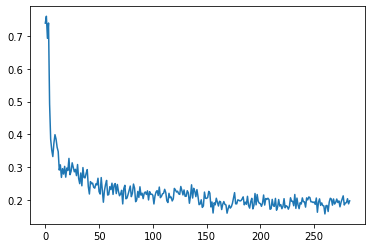

In [20]:
plt.plot(range(len(losses)), losses)

### Validating the net

In [21]:
y_train_pred = runner.predict(DataLoader(train_dl.dataset, train_dl.batch_size))

In [22]:
y_val_pred = runner.predict(validation_dl)

In [23]:
y_test_pred = runner.predict(test_dl)

#### Training

In [24]:
aucroc_train = roc_auc_score(target_train, y_train_pred)
print(f'Auc Roc in training: {aucroc_train}')

Auc Roc in training: 0.9158695112257733


#### Validation

In [25]:
aucroc_val = roc_auc_score(target_validation, y_val_pred)
print(f'Auc Roc in test: {aucroc_val}')

Auc Roc in test: 0.8657374153755061


#### Testing submission

In [26]:
submission = pd.DataFrame({
    'conversion': y_test_pred.squeeze()
}).reset_index().rename({'index':'ROW_ID'}, axis=1)
submission['conversion'] = np.round(submission['conversion'], 4)
submission.tail()

,ROW_ID,conversion
19206,19206,0.0738
19207,19207,0.1109
19208,19208,0.0003
19209,19209,0.0566
19210,19210,0.0005


In [27]:
submission.to_csv('submission_2020_09_22_002.csv.gz', compression='gzip', index=False)